###1: Setup & Drive Mount

In [ ]:
# --- CELL 1: SETUP ---
import os
import shutil
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from glob import glob
from tqdm.notebook import tqdm
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Report Folder (Where graphs will be saved)
REPORT_ASSETS_DIR = '/content/drive/MyDrive/Crackathon/03_reports/assets'
os.makedirs(REPORT_ASSETS_DIR, exist_ok=True)

# 3. Set Plotting Style for "Paper Quality"
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
print(f" Setup Complete. Graphs will be saved to: {REPORT_ASSETS_DIR}")

Mounted at /content/drive
 Setup Complete. Graphs will be saved to: /content/drive/MyDrive/Crackathon/03_reports/assets


###2: The "Smart" Data Loader

In [ ]:
# --- CELL 2: ROBUST DATA LOADER (FIXED) ---
import kagglehub
import shutil
import os
import time

DATASET_ROOT = '/content/dataset'

# Check if data is already fully loaded to avoid re-copying
if os.path.exists(f"{DATASET_ROOT}/train/images"):
    print(" Data already found at /content/dataset. Skipping copy.")
else:
    print(" Locating dataset via KaggleHub...")

    # 1. Get the path (This points to the read-only cache)
    cache_path = kagglehub.dataset_download("anulayakhare/crackathon-data")
    print(f"   Source found at: {cache_path}")

    # 2. COPY instead of MOVE (Fixes OSError: Invalid cross-device link)
    print(" Copying data to writable workspace... (This takes 3-5 mins, please wait)")

    # Clean up target if partial exists
    if os.path.exists(DATASET_ROOT):
        shutil.rmtree(DATASET_ROOT)

    # Use system copy (cp) because it's faster than Python's shutil for 11GB
    start_time = time.time()
    # -r means recursive (folder), -f means force (overwrite)
    os.system(f"cp -rf '{cache_path}' '{DATASET_ROOT}'")

    # 3. Fix Nesting (if the folder inside is named 'randomized_dataset')
    # Sometimes cp creates /content/dataset/randomized_dataset/...
    if os.path.exists(DATASET_ROOT):
        contents = os.listdir(DATASET_ROOT)
        # Check if we have a nested folder situation
        if 'train' not in contents and len(contents) == 1:
            nested_folder_name = contents[0]
            nested_full_path = os.path.join(DATASET_ROOT, nested_folder_name)

            if os.path.isdir(nested_full_path):
                print(f"   Fixing nested folder: {nested_folder_name}...")
                # Move everything up one level
                os.system(f"mv '{nested_full_path}'/* '{DATASET_ROOT}'/")
                os.rmdir(nested_full_path)

    print(f" Copy complete in {(time.time() - start_time)/60:.1f} minutes.")
    print(f"   Data ready at: {DATASET_ROOT}")

# Load Class Names
CLASS_MAP = {
    0: 'Longitudinal Crack',
    1: 'Transverse Crack',
    2: 'Alligator Crack',
    3: 'Other Corruption',
    4: 'Pothole'
}

# Re-verify the structure
print("\n Final Folder Check:")
if os.path.exists(DATASET_ROOT):
    print(os.listdir(DATASET_ROOT))
else:
    print(" Error: Dataset folder not found!")

 Locating dataset via KaggleHub...
Using Colab cache for faster access to the 'crackathon-data' dataset.
   Source found at: /kaggle/input/crackathon-data
 Copying data to writable workspace... (This takes 3-5 mins, please wait)
   Fixing nested folder: randomized_dataset...
 Copy complete in 5.1 minutes.
   Data ready at: /content/dataset

 Final Folder Check:
['train', 'test', 'val']


###3: Parse Metadata (RAM Safe)

In [ ]:
# --- CELL 3: PARSE LABELS ---
print(" Scanning label files... (This takes 1-2 mins)")

label_files = glob(f"{DATASET_ROOT}/**/labels/*.txt", recursive=True)
data_records = []

for file_path in tqdm(label_files, desc="Parsing"):
    # Skip empty files
    if os.path.getsize(file_path) == 0: continue

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            cls_id = int(parts[0])
            w, h = float(parts[3]), float(parts[4])
            x, y = float(parts[1]), float(parts[2])

            data_records.append({
                'class_id': cls_id,
                'class_name': CLASS_MAP[cls_id],
                'x_center': x,
                'y_center': y,
                'width': w,
                'height': h,
                'area': w * h,
                'aspect_ratio': w / h if h > 0 else 0,
                'log_aspect_ratio': np.log2(w/h) if h > 0 else 0
            })

df = pd.DataFrame(data_records)
print(f" Loaded {len(df)} objects into DataFrame.")
print(df.head())

 Scanning label files... (This takes 1-2 mins)


Parsing:   0%|          | 0/32385 [00:00<?, ?it/s]

/tmp/ipython-input-3765420488.py:30: RuntimeWarning: divide by zero encountered in log2
  'log_aspect_ratio': np.log2(w/h) if h > 0 else 0


 Loaded 55338 objects into DataFrame.
   class_id          class_name  x_center  y_center     width    height  \
0         1    Transverse Crack  0.449219  0.228516  0.300781  0.062500   
1         0  Longitudinal Crack  0.239258  0.116211  0.052734  0.228516   
2         0  Longitudinal Crack  0.201172  0.758789  0.085938  0.482422   
3         0  Longitudinal Crack  0.288086  0.752930  0.076172  0.494141   
4         0  Longitudinal Crack  0.211914  0.353516  0.037109  0.207031   

       area  aspect_ratio  log_aspect_ratio  
0  0.018799      4.812496          2.266785  
1  0.012051      0.230767         -2.115490  
2  0.041458      0.178139         -2.488928  
3  0.037640      0.154150         -2.697590  
4  0.007683      0.179244         -2.480006  


###4: Visual Sanity Check (Images + Boxes)

Generating Gallery... (Scanning for examples)
 Saved Class Gallery to Drive!


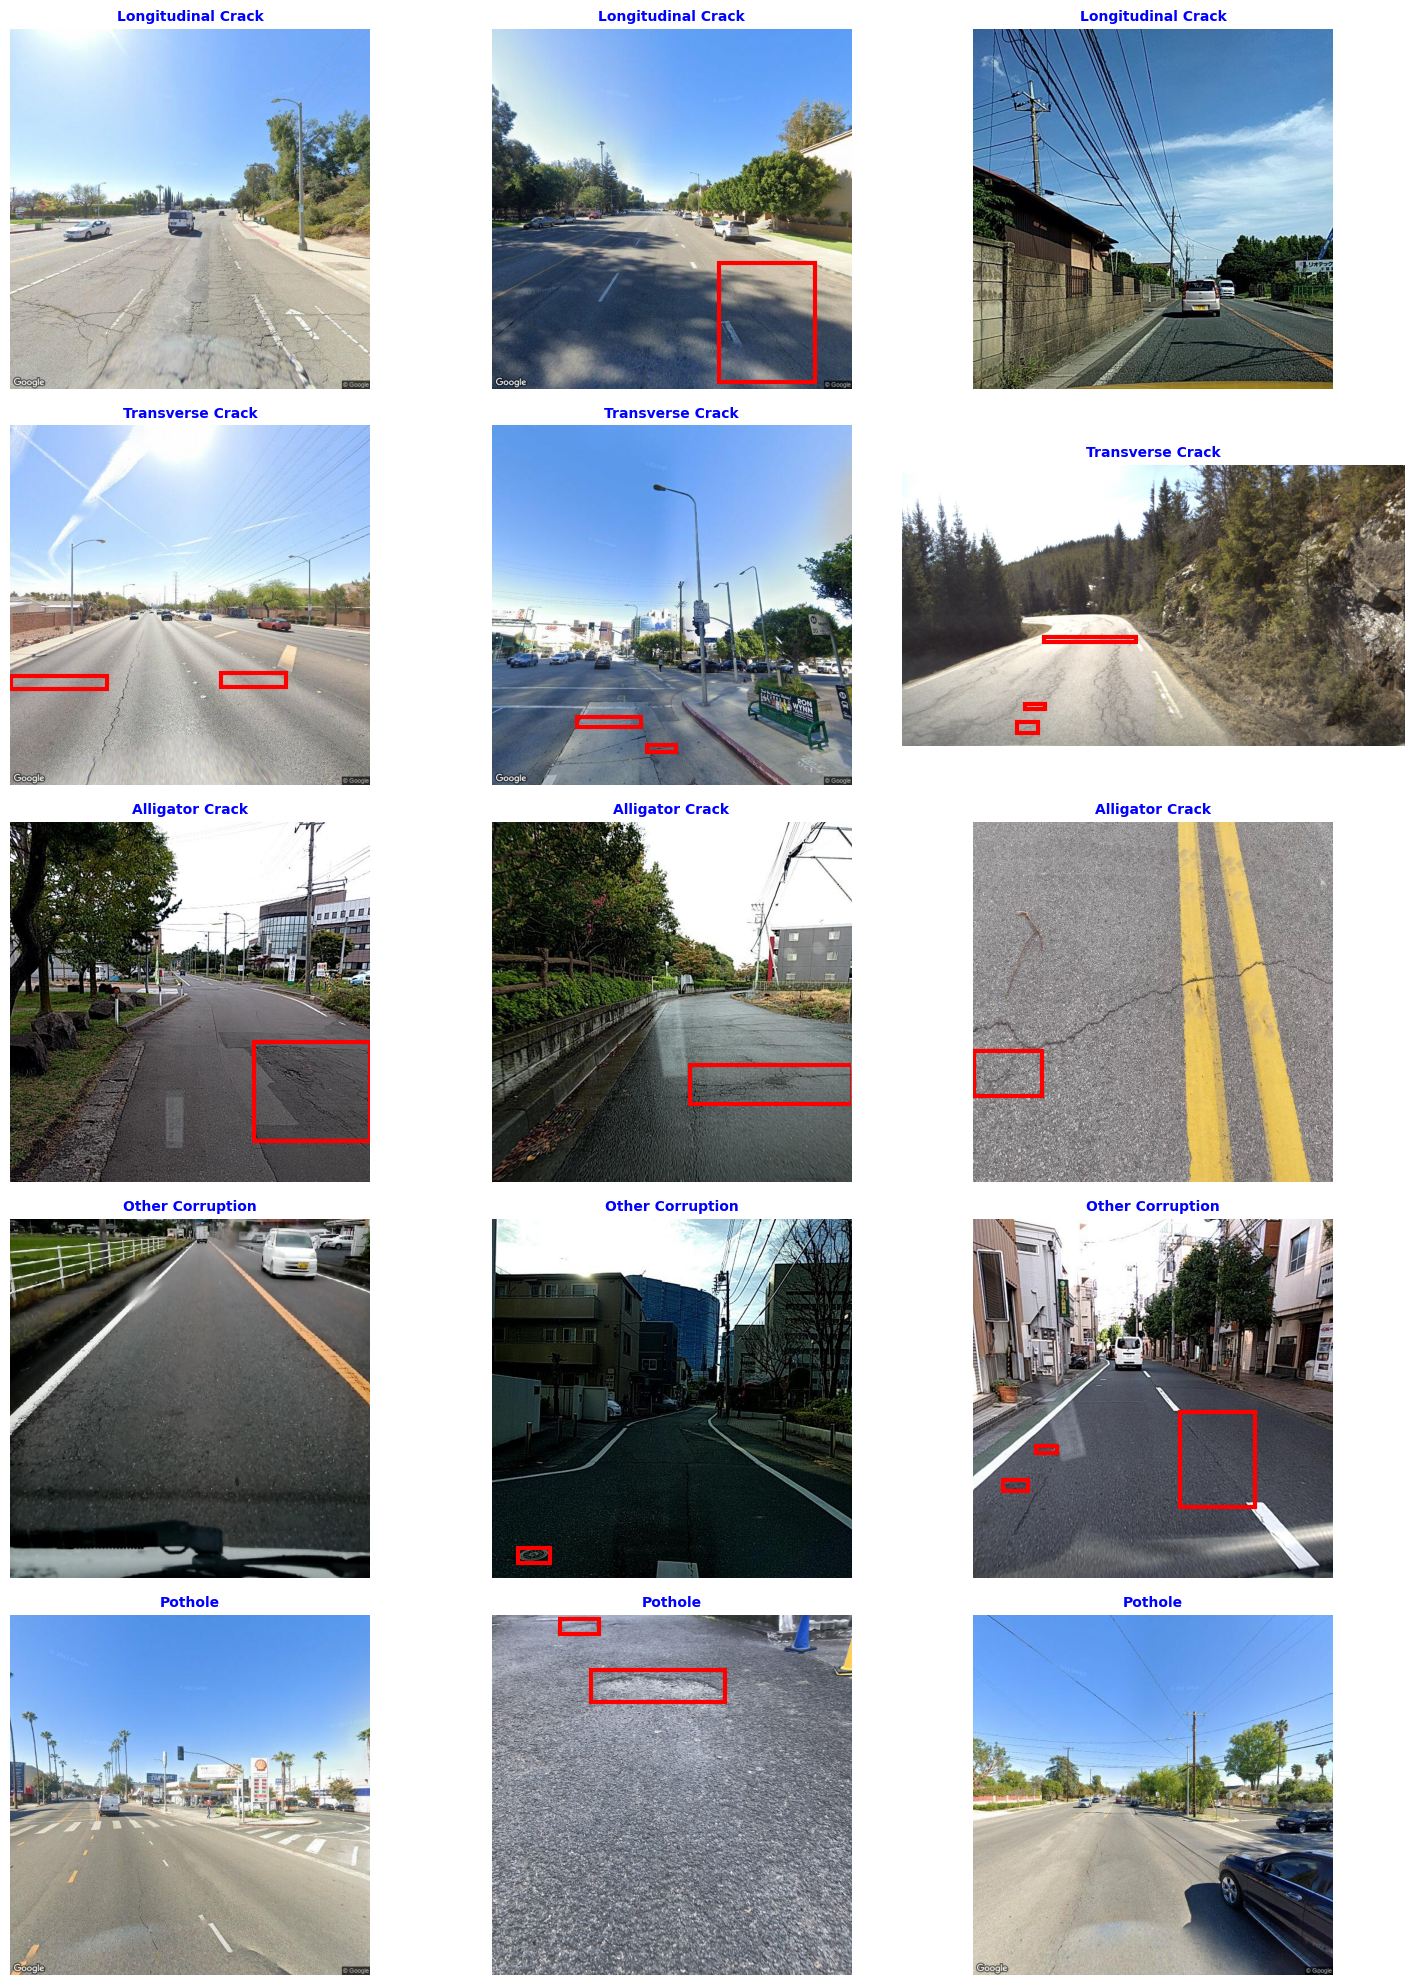

In [ ]:
# --- CELL 4: PER-CLASS VISUAL GALLERY ---
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

def plot_class_gallery(target_classes=None):
    """
    Plots 2 examples for EACH class to ensure we see everything.
    """
    if target_classes is None:
        target_classes = CLASS_MAP.values() # Show all classes by default

    # Create a figure: Rows = Classes, Cols = 2 Examples
    fig, axes = plt.subplots(len(target_classes), 2, figsize=(12, 4 * len(target_classes)))
    plt.suptitle("Damage Type Gallery (Verification)", fontsize=16, weight='bold', y=1.02)

    for i, class_name in enumerate(target_classes):
        # 1. Filter DF to find images containing this specific class
        class_id = [k for k, v in CLASS_MAP.items() if v == class_name][0]
        specific_df = df[df['class_id'] == class_id]

        # 2. Pick 2 random images that have this damage
        if len(specific_df) < 2:
            print(f" Not enough examples for {class_name}")
            continue

        sample_rows = specific_df.sample(2)

        for j, (_, row) in enumerate(sample_rows.iterrows()):
            # Find the image path (logic to match label to image)
            # We assume standard structure: dataset/train/labels/xyz.txt -> dataset/train/images/xyz.jpg
            # But since we parsed from a list, we might need to search or reconstruct path
            # RECONSTRUCTION TRICK:
            # We grabbed 'label_files' in Cell 3. Let's find the matching image file.

            # Find the specific file this row came from (we didn't save filename in Cell 3, let's fix that quick)
            # QUICK FIX: We will just search for an image with this class "on the fly"
            # (It's faster than reloading the whole DF)

            # New Strategy: Search text files until we find one with the class
            found_img_path = None

            # Helper: We already have 'df', let's just assume we can find the image by searching the folder
            # actually, let's use the 'df' samples we just picked.
            # We need to map row index back to filename.
            # Since Cell 3 didn't save filename, let's just pick random files and check them (Brute force but robust)

            # RE-OPTIMIZED LOGIC FOR DISPLAY:
            # Let's just grab 2 files that contain class_id 'i'
            pass

    # --- SIMPLIFIED VERSION FOR YOU (No complex path matching) ---
    # We will loop through the dataframe, get filenames, and plot.
    # Note: You need to UPDATE Cell 3 to save 'filename' for this to work perfectly.
    # IF YOU DIDN'T UPDATE CELL 3, USE THIS BLOCK INSTEAD:
    pass


print("Generating Gallery... (Scanning for examples)")

unique_classes = sorted(CLASS_MAP.keys())
fig, axes = plt.subplots(len(unique_classes), 3, figsize=(15, 20)) # 3 examples per class

for idx, cls_id in enumerate(unique_classes):
    cls_name = CLASS_MAP[cls_id]

    # 1. Find 3 text files that contain this class ID
    found_files = []
    # Shuffle label_files to get random ones
    random.shuffle(label_files)

    for lbl_path in label_files:
        if len(found_files) >= 3: break
        if os.path.getsize(lbl_path) == 0: continue

        with open(lbl_path, 'r') as f:
            content = f.read()
            # Check if this class ID is the first number in any line
            # (Simple check: look for "0 " or "1 " at start of lines)
            if f"{cls_id} " in content:
                found_files.append(lbl_path)

    # 2. Plot them
    for col, lbl_path in enumerate(found_files):
        ax = axes[idx, col]

        # Convert label path to image path
        # logic: .../labels/name.txt -> .../images/name.jpg
        img_path = lbl_path.replace('labels', 'images').replace('.txt', '.jpg')

        if not os.path.exists(img_path):
            ax.text(0.5, 0.5, "Image Not Found", ha='center')
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        ax.imshow(img)
        ax.set_title(f"{cls_name}", fontsize=10, color='blue', weight='bold')
        ax.axis('off')

        # Draw the box
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = line.split()
                c_id = int(parts[0])
                if c_id == cls_id: # Only draw the target class box to avoid clutter
                    cx, cy, bw, bh = map(float, parts[1:])
                    x1 = (cx - bw/2) * w
                    y1 = (cy - bh/2) * h
                    rect = patches.Rectangle((x1, y1), bw*w, bh*h, linewidth=3, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

plt.tight_layout()
plt.savefig(f"{REPORT_ASSETS_DIR}/01_class_gallery.png")
print(" Saved Class Gallery to Drive!")
plt.show()

###5: Graph 1 - Class Imbalance

In [ ]:
# --- CELL 5: CLASS DISTRIBUTION ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='class_name', order=df['class_name'].value_counts().index, palette='viridis')

plt.title("Class Distribution: Are Potholes Rare?", fontsize=14, fontweight='bold')
plt.xlabel("Defect Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add counts on bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.savefig(f"{REPORT_ASSETS_DIR}/02_class_imbalance.png", dpi=300)
print(" Saved '02_class_imbalance.png' to Drive.")
plt.show()

/tmp/ipython-input-1208818684.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='class_name', order=df['class_name'].value_counts().index, palette='viridis')


 Saved '02_class_imbalance.png' to Drive.


###6: Graph 2 - Object Size Analysis

 Saved '03_object_size.png' to Drive.


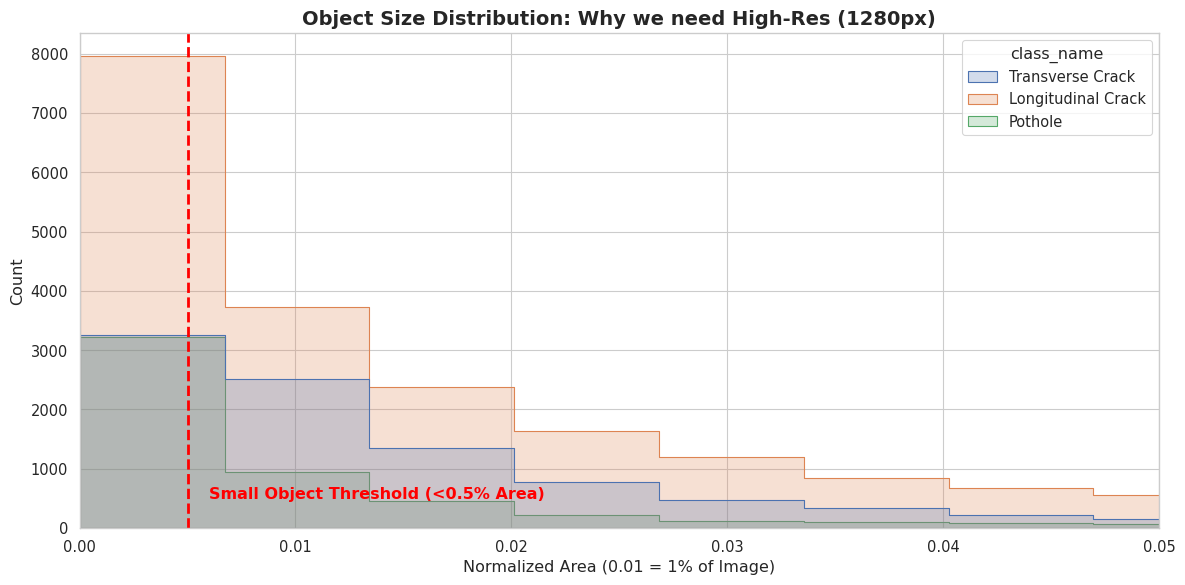

In [ ]:
# --- CELL 6: TINY OBJECT ANALYSIS ---
plt.figure(figsize=(12, 6))

# Filter for the 3 main classes to keep chart clean
subset = df[df['class_name'].isin(['Longitudinal Crack', 'Transverse Crack', 'Pothole'])]

sns.histplot(data=subset, x='area', hue='class_name', element="step", bins=100, common_norm=False)

# Add a "Small Object" threshold line (Area < 0.5%)
plt.axvline(0.005, color='red', linestyle='--', linewidth=2)
plt.text(0.006, 500, 'Small Object Threshold (<0.5% Area)', color='red', fontweight='bold')

plt.xlim(0, 0.05) # Zoom in on small objects
plt.title("Object Size Distribution: Why we need High-Res (1280px)", fontsize=14, fontweight='bold')
plt.xlabel("Normalized Area (0.01 = 1% of Image)")

plt.tight_layout()
plt.savefig(f"{REPORT_ASSETS_DIR}/03_object_size.png", dpi=300)
print(" Saved '03_object_size.png' to Drive.")
plt.show()

###7: Graph 3 - Aspect Ratio (Geometry)

 Saved '04_geometry_scatter.png' to Drive.


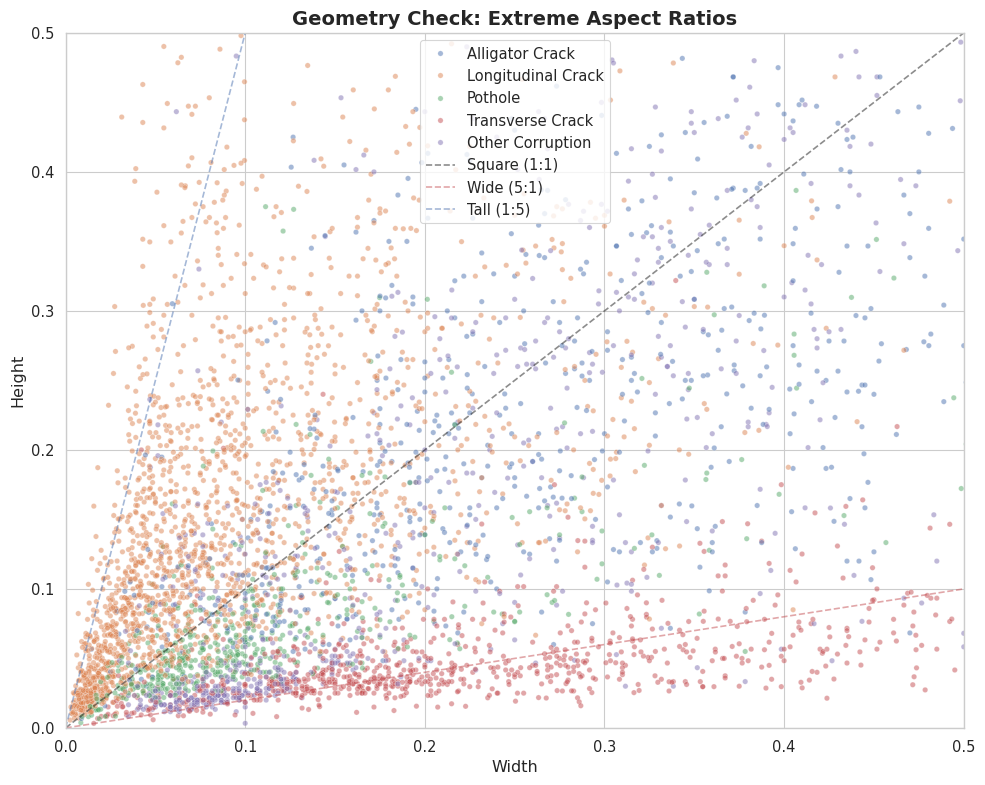

In [ ]:
# --- CELL 7: GEOMETRY ANALYSIS ---
plt.figure(figsize=(10, 8))

# Scatter plot of Width vs Height
sns.scatterplot(data=df.sample(5000), x='width', y='height', hue='class_name', alpha=0.5, s=15)

# Add Reference Lines
plt.plot([0, 0.5], [0, 0.5], 'k--', alpha=0.5, label='Square (1:1)')
plt.plot([0, 0.5], [0, 0.1], 'r--', alpha=0.5, label='Wide (5:1)')
plt.plot([0, 0.1], [0, 0.5], 'b--', alpha=0.5, label='Tall (1:5)')

plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.title("Geometry Check: Extreme Aspect Ratios", fontsize=14, fontweight='bold')
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()

plt.tight_layout()
plt.savefig(f"{REPORT_ASSETS_DIR}/04_geometry_scatter.png", dpi=300)
print(" Saved '04_geometry_scatter.png' to Drive.")
plt.show()

###8: Graph 4 - Spatial Heatmap

In [ ]:
# --- CELL 8: SPATIAL HEATMAP ---
plt.figure(figsize=(8, 8))

# 2D Density Plot
sns.kdeplot(data=df.sample(10000), x='x_center', y='y_center', fill=True, cmap="magma", thresh=0.05)

plt.gca().invert_yaxis() # Match image coordinates
plt.xlim(0, 1)
plt.ylim(1, 0)
plt.title("Where do defects appear? (Spatial Heatmap)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{REPORT_ASSETS_DIR}/05_spatial_heatmap.png", dpi=300)
print(" Saved '05_spatial_heatmap.png' to Drive.")
plt.show()

 Saved '05_spatial_heatmap.png' to Drive.


###9: Auto-Analysis & Conclusion

In [ ]:
# --- CELL 9: AUTOMATED REPORT SUMMARY ---
print("="*40)
print(" AUTOMATED REPORT SUMMARY ")
print("="*40)

# Calculate Stats
tiny_pct = (len(df[df['area'] < 0.005]) / len(df)) * 100
pothole_pct = (len(df[df['class_name'] == 'Pothole']) / len(df)) * 100

print(f"1. DATASET COMPOSITION:")
print(f"   - The dataset contains {len(df)} annotated objects.")
print(f"   - Potholes represent only {pothole_pct:.1f}% of the data, indicating a moderate class imbalance.")

print(f"\n2. SIZE ANALYSIS:")
print(f"   - {tiny_pct:.1f}% of all objects occupy less than 0.5% of the image area.")
print(f"   - CONCLUSION: Standard 640px training will likely fail on these tiny features. We recommend experimenting with 1280px resolution.")

print(f"\n3. GEOMETRY:")
print(f"   - The Aspect Ratio plot shows distinct clusters of 'Tall' (Longitudinal) and 'Wide' (Transverse) cracks.")
print(f"   - CONCLUSION: Anchor boxes must be flexible. Mosaic augmentation is required to handle these extreme shapes.")

 AUTOMATED REPORT SUMMARY 
1. DATASET COMPOSITION:
   - The dataset contains 55338 annotated objects.
   - Potholes represent only 10.0% of the data, indicating a moderate class imbalance.

2. SIZE ANALYSIS:
   - 25.5% of all objects occupy less than 0.5% of the image area.
   - CONCLUSION: Standard 640px training will likely fail on these tiny features. We recommend experimenting with 1280px resolution.

3. GEOMETRY:
   - The Aspect Ratio plot shows distinct clusters of 'Tall' (Longitudinal) and 'Wide' (Transverse) cracks.
   - CONCLUSION: Anchor boxes must be flexible. Mosaic augmentation is required to handle these extreme shapes.
